In [1]:
%reload_ext autoreload

from source import *

%autoreload

# Loading data

#### Loading patient_file information...

In [2]:
#data = Processing.json_to_df()
data = pd.read_csv(Params.PATIENT_FILE_LOCATION_NEW)
data[Params.AGE] = Params.CURRENT_YEAR - data["birth_year"]
data[Params.PATIENT_ID] = data[Params.PATIENT_ID].astype(str)
data["infected_by"] = data["infected_by"].astype(str).str[:-2]
data = data.drop(["global_num", "birth_year", "country", "infection_order"], axis = 1)

#### Loading data routes information...

In [3]:
patient_routes = pd.read_csv(Params.PATIENT_ROUTES_FILE_LOCATION)

#### Loading case information...

In [4]:
case_data = pd.read_csv(Params.CASE_FILE_LOCATION)

#### Loading Region information...

In [5]:
region_data = pd.read_csv(Params.REGION_FILE_LOCATION)

#### Loading searchTrend information...

In [6]:
search_trend_data = pd.read_csv(Params.SEARCH_TREND_FILE_LOCATION)

#### Loading Time information...

In [7]:
time_data = pd.read_csv(Params.TIME_FILE_LOCATION)

#### Loading TimeAge information...

In [8]:
time_age_data = pd.read_csv(Params.TIME_AGE_FILE_LOCATION)

#### Loading TimeGender information...

In [9]:
time_gender_data = pd.read_csv(Params.TIME_GENDER_FILE_LOCATION)

#### Loading TimeProvince information...

In [10]:
time_province_data = pd.read_csv(Params.TIME_PROVINCE_FILE_LOCATION)

#### Loading graph information...

In [11]:
graph_data = pd.read_pickle(Params.GRAPH_DATA_FILE_LOCATION).drop("city", axis = 1).fillna(0)
graph_data[Params.PATIENT_ID] = graph_data[Params.PATIENT_ID].astype(str)

In [12]:
data.columns =  [
    Params.PATIENT_ID,
    Params.SEX,
    Params.AGE,
    Params.PROVINCE,
    Params.CITY,
    Params.OTHER_DISEASE,
    Params.INFECTION_CASE,
    Params.INFECTOR_ID,
    Params.NUMBER_OF_CONTACTS,
    Params.SYMPTOM_ONSET_DATE,
    Params.CONFIRMED_DATE,
    Params.RELEASED_DATE,
    Params.DEATH_DATE,
    Params.STATE
]

# Processing and Analysis

#### Converting date strings to datetime data type...

In [13]:
data[Params.SYMPTOM_ONSET_DATE] = Processing.convert_column_to_datetime(data[Params.SYMPTOM_ONSET_DATE])
data[Params.CONFIRMED_DATE] = Processing.convert_column_to_datetime(data[Params.CONFIRMED_DATE])
data[Params.RELEASED_DATE] = Processing.convert_column_to_datetime(data[Params.RELEASED_DATE])
data[Params.DEATH_DATE] = Processing.convert_column_to_datetime(data[Params.DEATH_DATE])


In [14]:
data.dtypes

patient_id                    object
sex                           object
age                          float64
province                      object
city                          object
other_disease                 object
infection_case                object
infector_id                   object
number_of_contacts           float64
symptom_onset_date    datetime64[ns]
comfirmed_date        datetime64[ns]
released_date         datetime64[ns]
death_date            datetime64[ns]
state                         object
dtype: object

In [15]:
patient_routes.dtypes

patient_id      int64
global_num    float64
date           object
province       object
city           object
type           object
latitude      float64
longitude     float64
dtype: object

#### Number of patients in each state

In [16]:
data.groupby("state").count()[["patient_id"]]

,patient_id
state,
deceased,67
isolated,1747
released,1439


#### Average age of people in each of the different states...

In [17]:
data.groupby("state").mean()[["age"]]

,age
state,
deceased,74.269841
isolated,46.415525
released,42.256265


#### Get the percentage of the infectors that also appear as patients...

In [18]:
print("The percentage of the infectors that also appear as patient_ids: {:.2f} %".format(
    Analysis.perc_of_infectors_who_are_patients(data) * 100))


The percentage of the infectors that also appear as patient_ids: 98.82 %


#### Keeping only the patients with non-null age...

In [19]:
#data = data[(data[Params.STATE] != "isolated") & (~data[Params.AGE].isnull())]
data = data[~data[Params.AGE].isnull()]

#### Get the admission date from patient routes information and join it to patient info dataset...

In [20]:
joined_data = Processing.enhance_patient_info_with_admission_date_info(data, patient_routes)

#### Histogram of the number of days spent in hospital (RELEASED PATIENTS)

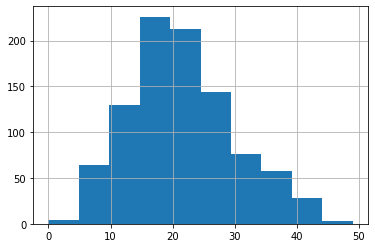

In [21]:
(joined_data[Params.RELEASED_DATE] - joined_data[Params.ADMISSION_DATE]).dt.days.hist()

#### Histogram of the number of days spent in hospital (DECEASED PATIENTS)

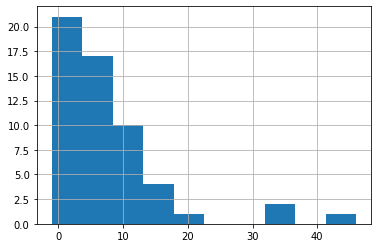

In [22]:
(joined_data[Params.DEATH_DATE] - joined_data[Params.ADMISSION_DATE]).dt.days.hist()

#### Histogram of the number of days spent in hospital (CURRENT ISOLATED PATIENTS)

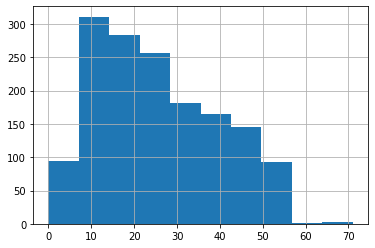

In [23]:
isolated_data = joined_data[joined_data[Params.STATE] == "isolated"]
(Params.MOST_RECENT_DATE_RECORDED - isolated_data[Params.ADMISSION_DATE]).dt.days.hist()

#### Get the average days spent in hospital per status...

In [24]:
#Analysis.get_avg_of_staying_in_hospital_per_state(joined_data)

#### Map state to severity of case and discard the released ones without a released date or the censored isolated ones...

In [25]:
joined_data = Processing.map_state_to_severity(joined_data)

/home/andreas/Documents/python-projects/corona_hackathon/source/Processing.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deceased_patients[Params.STATE] = Params.SEVERE
/home/andreas/Documents/python-projects/corona_hackathon/source/Processing.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isolated_patients["days_in_hospital"] = (current_date - isolated_patients[Params.ADMISSION_DATE]).dt.days
/home/andreas/anaconda3/envs/ba_env/lib/python3.7/site-packages/pandas/core/indexing.py:966: Setting

#### Distribution of classes...

In [26]:
joined_data.groupby(Params.STATE).count()

,patient_id,sex,age,province,city,other_disease,infection_case,infector_id,number_of_contacts,symptom_onset_date,comfirmed_date,released_date,death_date,admission_date
state,,,,,,,,,,,,,,
mild,919,919,919,919,914,0,437,919,197,88,919,919,0,919
severe,351,351,351,351,313,17,173,351,41,37,351,27,56,351


#### Join patient information to the infector's information...

In [27]:
#joined_data = Processing.join_patient_data_with_infector_data(joined_data)

#### Re-grouping and imputing infection case data...

In [28]:
joined_data = Processing.group_infected_cases(joined_data)

#### Creating the days_from_symptoms group column...

In [29]:
#joined_data = Processing.create_diff_between_symptoms_and_admission_feature(joined_data)

#### Joining with the region data...

In [30]:
joined_data = Processing.join_and_proc_patient_data_with_region_data(joined_data, region_data)

/home/andreas/anaconda3/envs/ba_env/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Join with the graph information...

In [31]:
joined_data = pd.merge(joined_data, graph_data[[Params.PATIENT_ID] + Params.GRAPH_COLUMNS_TO_BE_USED],
                       on = Params.PATIENT_ID, how = "left").fillna(0)

#### Rename columns of dataset...

In [32]:
joined_data = joined_data.rename(Params.COLUMN_RENAME_DICT, axis = 1)

# Modelling

#### Discarding the columns not used in the modelling stage

In [33]:
data = joined_data.drop(Params.COLUMNS_NOT_USED_FOR_MODELLING, axis = 1)

#### Adding distinguishing prefix to the values of the categorical columns...

In [34]:
data = Processing.add_prefix_to_values_of_categorical_columns(data)

#### Perform one-hot encoding of the categorical columns...

In [35]:
data = Processing.perform_one_hot_encoding(data)

#### Splitting the dataset from the label...

In [36]:
y = data[Params.STATE]
X = data.drop(Params.STATE, axis = 1)

#### Convert state to binary label...

In [37]:
y = Processing.map_state_to_binary_labels(y)

#### Splitting into training and test set...

In [38]:
traintest = Modelling.split_to_train_test(X, y)

#### Further split training set to cross validation pairs...

In [39]:
cross_val_pairs = Modelling.generate_cross_val_data_without_restrictions(traintest)

#### Training and evaluating a Random Forest model using the cross-validation pairs...

accuracy: 0.87
precision: 0.85
recall: 0.68


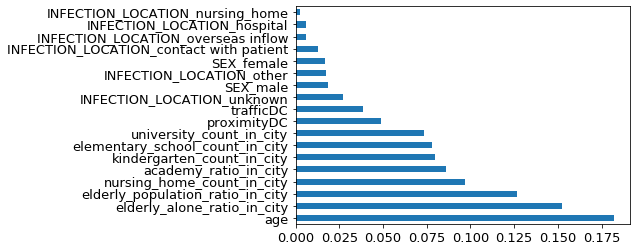

In [40]:
MODEL = RandomForestClassifier(n_estimators = Params.RFC_N_ESTIMATORS, 
                               criterion = Params.RFC_CRITERION,
                               max_depth = Params.RFC_MAX_DEPTH,
                              random_state = Params.RANDOM_STATE
                              )

cross_val_res = Modelling.apply_classification(MODEL, cross_val_pairs, get_importances = True)

cross_val_res.tostring()

#### Obtaining generalization estimate using the test set...

accuracy: 0.89
precision: 0.89
recall: 0.62


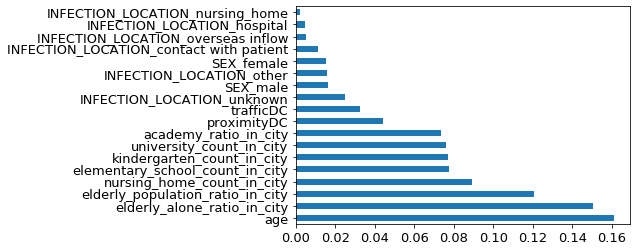

In [41]:
MODEL = RandomForestClassifier(n_estimators = Params.RFC_N_ESTIMATORS, 
                               criterion = Params.RFC_CRITERION,
                               max_depth = Params.RFC_MAX_DEPTH,
                              random_state = Params.RANDOM_STATE
                              )


generalization_estimate = Modelling.apply_classification(MODEL, [traintest], get_importances = True)

generalization_estimate.tostring()

# (Testing of methods)

In [42]:
test_joined_df = pd.DataFrame({Params.PATIENT_ID: [1,
                                                   2,
                                                   3,
                                                   4,
                                                   5,
                                                   6,
                                                   7,
                                                   8],
                               
    Params.STATE: ["deceased",
                                             "deceased",
                                             "released",
                                             "released",
                                             "released",
                                             "isolated",
                                             "isolated",
                                             "isolated"],
                               Params.ADMISSION_DATE: [datetime.datetime(2019,11,11),
                                                      datetime.datetime(2019,11,14),
                                                      datetime.datetime(2019, 11, 11),
                                                      datetime.datetime(2019, 11, 11),
                                                      datetime.datetime(2019, 11, 12),
                                                      datetime.datetime(2019, 12, 11),
                                                      datetime.datetime(2019, 11, 11),
                                                      datetime.datetime(2019, 10, 12)],
                               Params.RELEASED_DATE: [np.nan,
                                                     np.nan,
                                                     np.nan,
                                                     datetime.datetime(2019, 11, 20),
                                                     datetime.datetime(2019, 12, 15),
                                                     np.nan,
                                                     np.nan,
                                                     np.nan]
                              }).set_index(Params.PATIENT_ID)
Processing.map_state_to_severity(test_joined_df, 30, datetime.datetime(2019, 12,16)).sort_index()

/home/andreas/Documents/python-projects/corona_hackathon/source/Processing.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deceased_patients[Params.STATE] = Params.SEVERE
/home/andreas/Documents/python-projects/corona_hackathon/source/Processing.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isolated_patients["days_in_hospital"] = (current_date - isolated_patients[Params.ADMISSION_DATE]).dt.days
/home/andreas/anaconda3/envs/ba_env/lib/python3.7/site-packages/pandas/core/indexing.py:966: Setting

,state,admission_date,released_date
patient_id,,,
1,severe,2019-11-11,NaT
2,severe,2019-11-14,NaT
4,mild,2019-11-11,2019-11-20
5,severe,2019-11-12,2019-12-15
7,severe,2019-11-11,NaT
8,severe,2019-10-12,NaT


In [43]:
test_joined_df = pd.DataFrame({
    "patient_id": ["1",
                  "2",
                  "3",
                  "4",
                  "5",
                  "6"], 
     "age": [21,
             31,
             41,
             51,
             61,
             78],
     "sex": ["male",
             "female",
             "female",
             "female",
             "male",
             "male"],
     "infector_id": ["n",
                    "1",
                    "n",
                    "2",
                    "3",
                    "4"]
})

Processing.join_patient_data_with_infector_data(test_joined_df)

,patient_id,age,sex,infector_id,infector_age,infector_sex
0,1,21,male,n,unknown,unknown
1,2,31,female,1,20s_30s,male
2,3,41,female,n,unknown,unknown
3,4,51,female,2,20s_30s,female
4,5,61,male,3,50s_60s,female
5,6,78,male,4,50s_60s,female


In [44]:
test_joined_df = pd.DataFrame({"age": [30,31,32,33,34,35], 
                               "province": ["Seoul",
                                                       "Seoul",
                                                       "Seoul",
                                                       "Busan",
                                                      "Busan",
                                                      "Busan"], 
                               "city": ["Seoul",
                                        "other1",
                                        "etc",
                                        "Busan",
                                       "other2",
                                       "etc"]})
test_region_df = pd.DataFrame({"province": ["Seoul",
                                            "Seoul",
                                            "Seoul",
                                            "Busan",
                                            "Busan",
                                            "Busan"], 
                               "city" : ["Seoul",
                                         "other1",
                                         "other2",
                                        "Busan",
                                        "other1",
                                        "other2"],
                               "kindergardens": [100,
                                                 10,
                                                 20,
                                                 50,
                                                 10,
                                                 5], 
                               "schools": [200,
                                          20,
                                          30,
                                          100,
                                          25,
                                          15]})
Processing.join_and_proc_patient_data_with_region_data(test_joined_df, test_region_df, ["kindergardens", "schools"])

/home/andreas/anaconda3/envs/ba_env/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,age,province,city,kindergardens,schools
4,34,Busan,other2,5.0,15.0
5,35,Busan,etc,7.5,20.0
1,31,Seoul,other1,10.0,20.0
2,32,Seoul,etc,15.0,25.0
0,30,Seoul,Seoul,100.0,200.0
3,33,Busan,Busan,50.0,100.0


In [45]:
test_df = pd.DataFrame({Params.ADMISSION_DATE: [datetime.datetime(2019, 11, 11), 
                                               datetime.datetime(2019, 11, 13),
                                                datetime.datetime(2019, 11, 13),
                                                datetime.datetime(2019, 11, 13),
                                                datetime.datetime(2019, 11, 15),
                                                datetime.datetime(2019, 11, 19),
                                                datetime.datetime(2019, 11, 29)
                                               ],
                        Params.SYMPTOM_ONSET_DATE: [datetime.datetime(2019, 11, 12),
                                                    datetime.datetime(2019, 11, 11),
                                                    np.nan,
                                                    None,
                                                    datetime.datetime(2019, 11, 11),
                                                    datetime.datetime(2019, 11, 11),
                                                    datetime.datetime(2019, 11, 11)
                                                   ]})
Processing.create_diff_between_symptoms_and_admission_feature(test_df)

,admission_date,symptom_onset_date,days_between_symptoms_and_admissions
0,2019-11-11,2019-11-12,no_symptoms_at_admission
1,2019-11-13,2019-11-11,symptoms_1_to_2_days_before_admission
2,2019-11-13,NaT,unknown
3,2019-11-13,NaT,unknown
4,2019-11-15,2019-11-11,symptoms_3_to_5_days_before_admission
5,2019-11-19,2019-11-11,symptoms_6_to_10_days_before_admission
6,2019-11-29,2019-11-11,symptoms_more_than_10_days_before_admission


In [46]:
test_df = pd.DataFrame({Params.INFECTION_CASE : ["Pilgrimage to Israel",
                                       "River of Grace Community Church",
                                       "Geochang Church",
                                       "Milal Shelter",
                                       "Eunpyeong St. Mary's Hospital",
                                       "Ministry of Oceans and Fisheries",
                                       "overseas inflow",
                                       None,
                                       np.nan,
                                       "contact with patient",
                                       "Bonghwa Pureun Nursing Home"
                                      ]})


Processing.group_infected_cases(test_df)

,infection_case
0,other
1,other
2,other
3,other
4,hospital
5,other
6,overseas inflow
7,unknown
8,unknown
9,contact with patient
